# Measuring Telehealth Service Access in New Hampshire
### GEOG 50.03 Final Project
By Aryeh Lande, Lorraine Liu, Emily Luy Tan

## Table of Content
* Background
* Research Question
* Necessary Imports
* Creating a Network Layer & Computing Service Area
* High-need Demographics
    * Population 65+
    * Access to the Internet
    * Internet Speeds
* Areas Outside of the Service Area
* Data Analysis & Conclusion
* Possible Limitations
* Bibliography

## Background

**Telehealth** (aka telemedicine) is the use of telecommunication technologies to provide care from a doctor without needing to be in the same place. Historically, telehealth has been developed at a slow rate but the recent pandemic has forced its rapid implementation. In the early days of the pandemic, the federal government reported that 44 percent of Medicare-funded primary care visits were conducted virtually; that figure was 0.1 percent in February of 2020. While there has been a dramatic rise in the use of telehealth, the demand for it is even higher. **Access to telehealth does not fall equally across populations or geographies.** Recent research has highlighted racial, age, and internet access disparities limit access to telehealth nationally. This **“digital divide”** was a concern that preceded COVID, and now the broader migration to digital formats might widen such disparities. 

## Research Question

For our project, we will look at access to telehealth across New Hampshire.
***
In doing so, we seek to answer the question... 

   **Who and where are the population that would benefit from better access to telehealth?**
***

In order to answer this question, we map and analyze a variety of data:
* Service Areas of health factilities in New Hampshire
* New Hampshire Census Tracts
* Health Facilities
* High-need Demographics by Census tract
* Internet Access by Census tract
* Internet Service Speeds by Census block


## Necessary Imports and Connect to GIS

In [1]:
from arcgis.gis import GIS
gis = GIS("home")
from arcgis.features import FeatureLayer
from arcgis.mapping import WebMap
from IPython.display import HTML
import pandas as pd

## Creating a Network Layer

Beyond the pandemic, one reason why someone could benefit from telehelath is because they are not close enough to a health facility for easy in-person care. In order to understand which populations/geogarphies are a significant distance from health facilities, we used the `network` module of the ArcGIS API for Python can be used to construct service areas.

The service areas were defined as the areas within a 30 minute drive from a hospital. 

To create the service areas, we create a `ServiceAreaLayer` which is a type of `NetworkLayer`. First, we import the `network` module.

In [2]:
import arcgis.network as network

In [3]:
service_area_url = gis.properties.helperServices.serviceArea.url
service_area_url

'https://route.arcgis.com/arcgis/rest/services/World/ServiceAreas/NAServer/ServiceArea_World'

In [4]:
sa_layer = network.ServiceAreaLayer(service_area_url, gis=gis)

### Hospital Data for Network Analysis 

We imported a `Feature Layer Collection` of points that represented major hospitals in NH. These points will be used as our "facilities" around which the service areas will be created.

<Item title:"New_Hampshire_Hospitals" type:Feature Layer Collection owner:f003ddw_Dartmouth>
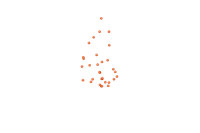

In [5]:
## Import NH Hospitals
NH_Hospitals = gis.content.search("https://services1.arcgis.com/ajkPMiuiqxF9xEgP/arcgis/rest/services/New_Hampshire_Hospitals/FeatureServer",'feature layer')[0]
NH_Hospitals

We also imported the NH Census tract data in the same way, though these are polygons rather than points.

<Item title:"Census tracts" type:Feature Layer Collection owner:f003ddw_Dartmouth>
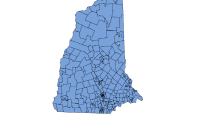

In [6]:
## Import Census Tracts
census_tract = gis.content.search("https://services1.arcgis.com/ajkPMiuiqxF9xEgP/arcgis/rest/services/Census_tracts/FeatureServer",'feature layer')[0]
census_tract

## Computing health facility service area

To compute the service area (area accessible to each hospital based on drive times), we use the `solve_service_area()` method of a `ServiceAreaLayer` object.

In [7]:

result = sa_layer.solve_service_area(NH_Hospitals, default_breaks=[30], 
                                     travel_direction='esriNATravelDirectionFromFacility', overlap_polygons=False)

We then look at the keys within the dictionary service area in `result`. From these keys, we can figure out which keys are needed to make a feature set to display on a map.

In [8]:
result.keys()

dict_keys(['messages', 'saPolygons'])

In [9]:
result['saPolygons'].keys()

dict_keys(['fieldAliases', 'geometryType', 'spatialReference', 'features'])

In [10]:
from arcgis.features import Feature, FeatureSet

We are now able to use these types from the arcgis.features module.

In [11]:
poly_feat_list = []
for polygon_dict in result['saPolygons']['features']:
    f1 = Feature(polygon_dict['geometry'], polygon_dict['attributes'])
    poly_feat_list.append(f1)

In [12]:
service_area_fset = FeatureSet(poly_feat_list, 
                         geometry_type=result['saPolygons']['geometryType'],
                         spatial_reference= result['saPolygons']['spatialReference'])

We inspect the service area as a Pandas DataFrame to understand the attribute information.

In [13]:
service_area_df = service_area_fset.sdf
service_area_df

,ObjectID,FacilityID,Name,FromBreak,ToBreak,Shape_Length,Shape_Area,SHAPE
0,1,17,CONCORD HOSPITAL : 0 - 24.1859951569205,0,24.185995,0.760060,0.014935,"{""rings"": [[[-71.69758331999998, 43.3241720090..."
1,2,25,THE CHESHIRE MEDICAL CENTER : 0 - 30,0,30.000000,7.152957,0.150476,"{""rings"": [[[-72.12270908399995, 43.1923448440..."
2,3,29,NORTHEAST REHABILITATION : 0 - 30,0,30.000000,2.148860,0.049621,"{""rings"": [[[-71.69623585299996, 42.9599068270..."
3,4,13,MONADNOCK COMMUNITY HOSPITAL : 0 - 30,0,30.000000,4.025542,0.115740,"{""rings"": [[[-71.94708924899999, 43.1847091990..."
4,5,12,SAINT JOSEPH HOSPITAL AND TRAUMA CENTER : 0 - 30,0,30.000000,3.797857,0.061421,"{""rings"": [[[-71.49478957199995, 42.8265076180..."
5,6,30,SOUTHERN NEW HAMPSHIRE MEDICAL CENTER : 0 - 21...,0,21.441245,1.558327,0.015564,"{""rings"": [[[-71.47255637099994, 42.8673807760..."
6,7,31,CROTCHED MOUNTAIN REHABILITATION CENTER : 0 - 30,0,30.000000,1.030452,0.027103,"{""rings"": [[[-71.85186826399996, 43.0935306140..."
7,8,27,CATHOLIC MEDICAL CENTER : 0 - 30,0,30.000000,1.824691,0.039021,"{""rings"": [[[-71.52308637399994, 43.0908356810..."
8,9,15,HEALTHSOUTH REHABILITATION HOSPITAL : 0 - 1.66...,0,1.661092,0.020991,0.000002,"{""rings"": [[[-71.56440868799996, 43.2015525330..."
9,10,14,NEW HAMPSHIRE HOSPITAL : 0 - 30,0,30.000000,3.604176,0.132577,"{""rings"": [[[-71.57406553399994, 43.4582449510..."


The `SHAPE` attribute houses the service area as polygons, a geometry type.

In [14]:
service_area_fset.sdf['SHAPE']

0     {"rings": [[[-71.69758331999998, 43.3241720090...
1     {"rings": [[[-72.12270908399995, 43.1923448440...
2     {"rings": [[[-71.69623585299996, 42.9599068270...
3     {"rings": [[[-71.94708924899999, 43.1847091990...
4     {"rings": [[[-71.49478957199995, 42.8265076180...
5     {"rings": [[[-71.47255637099994, 42.8673807760...
6     {"rings": [[[-71.85186826399996, 43.0935306140...
7     {"rings": [[[-71.52308637399994, 43.0908356810...
8     {"rings": [[[-71.56440868799996, 43.2015525330...
9     {"rings": [[[-71.57406553399994, 43.4582449510...
10    {"rings": [[[-72.25812949299996, 43.5754745600...
11    {"rings": [[[-72.60936916299994, 43.8685485810...
12    {"rings": [[[-72.12360739499996, 43.9693840100...
13    {"rings": [[[-71.91789413599997, 43.6244325190...
14    {"rings": [[[-71.64346007199998, 43.6170214520...
15    {"rings": [[[-71.41753481099994, 43.7335773270...
16    {"rings": [[[-71.68276118599994, 44.1079485090...
17    {"rings": [[[-72.01872956499994, 44.399001

### Visualizing the hospitals and their service areas

We first make a base map. Then we add the service area geometries to the map using `.draw`.

In [15]:
##Map set to NH state
map1 = gis.map("NH", zoomlevel=7)
map1.basemap = 'gray-vector'
map1

MapView(layout=Layout(height='400px', width='100%'))

In [16]:
colors = [255, 255, 0, 90]

fill_symbol = {"type": "esriSFS","style": "esriSFSSolid",
               "color": [115,76,0,255]}

In [17]:
for service_area in service_area_fset.features:
    
    #set color based on drive time
    fill_symbol['color'] = colors
    
    #set popup
    popup={"title": "Service area",
            "content": "Area within a {} minute drive of {}".format(service_area.attributes['ToBreak'], service_area.attributes['Name'])}
    
    map1.draw(service_area.geometry, symbol=fill_symbol, popup=popup)

On top of these polygons, we add the hospital points. You can click on a service area to see the hospital it's associated with or you can click on a specific point to get more info about it.

In [18]:
#Add NH_Hospitals layer to the map.

map1.add_layer(NH_Hospitals)


In [19]:
#create popup for hopsital data
from IPython.display import HTML
for NH_Hospitals.ID in NH_Hospitals:
    popup_p={"title": "Hospital Name",
            "content": "NH_Hospitals('name')"}
    symbol_h = {"angle":0,"xoffset":0,"yoffset":0,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/OCHA/Infrastructure/infrastructure_hospital_bluebox.png","imageData":"iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAARISURBVHhe7ZtJbxNJHMXbIFZBBggnBBIcZiSGAQ58AfgAiAscQQQQEJIYJGbECAGR4AYXxAeAC8sBsScx2yRCAiaXUcSuObAMdhIkshBiZzF2F/9f444qngo2rQi16SrpuZzurlfvPVev6XKUUuOQd90pUsf43pMedc61JzdsPd3RuOJIW3tVXbOaV9/i/lTfosIItKERrWhGOx4K3mIFb+P8jvvD32Akm3dO3nm5cc3Re/en7byhwJw9zcZOwwi0+rrxgBc86R59jH3J5d2p1C+6B5esPf7gsrP9upqxq0ktiCfc+fFELsy/fDHQima04wEveMKb7hV4H34qT1IDi385+FfH1B3XVfXeRH5+QyJn6qCSgAe84AlveNQ9j+3z/75LY/4RiVXHE1kTWSUDT3jDI17xjHcJQE3JjORi6048vOL98vGbn0wEOiRVtxRkGBrbBgFcpj6KYWqrA294xCue8e7tAqfuvtrkbL9GSiWHfJVgVm2TmrV7YswUzP1yxjByfAvggAtOU19jEE1oM3HowCNe8eztAj2Do9PlSPlQhkeeA4epkQ86kANLbvmh1u7fDrd2rZgAqxvbUov238rMEeEmnm8BHHDBaeoLoAVNaCsVAh7xime8O+fbU+vldDFCY9lgwmEkQ8xL+tdDrQNPOz8+T/UNdb3tHepMSq3j9ftMV/eH4dS2Mx2ZWI03qox85YC2cMAFJ9zF/aEBLWhCGxrRauIrwMUrnvHu1JzuOMb5UhZ+dd+HdKYcRFYdaRtIj+Z6ZPh8tey98FQ5W69yNjHylQPawgFXqYImtKGxRACeVzzj3ZGrpr+5cODcadrYhx/ASulErq665Qjqyvk0T61j5JMslLr+/JNJCwAunVuHrwFNaCsnALziGe9OVZ15o2LoAfRlsu9I3XWV68WvlWzuy6KGSQwALorPrRdfA5rKDcAH3h35UtYV3o8YgMAlANOK/+EHDcAbAcYVxbAB2ABsADYAG4ANwAZgA7AB2ADKCyAuomM1V9XCfQk1r0HuwAKAtnDARamoAPacfayczZe9p0iza5sDgbZwwEWpqAD+vPR8tLq+Jf3zwbuZZQeCgbZwwKVz6yV0AUjxlvVnsv3/9Q4lU/3DXam+4c5AkLZwwOUxF7j1EsYAvmsJbQCywmX9pMCjMxfWU9sRYAMI2y4g63L58U9wgwCOUv1Q2xEQlgD8Bcm+4Z5/3nx4+Tg58ObR22CgLRxwwWlKO3QB+Bcrf1x8lp5b2/R+6YE7vYt/vx0ItIUDLp1bL6ENoO6cXApvueJd0/NfmCCgLRxwUSoqgMLNkCs3NK4YCQTawlGRN0P2eYANwAZgA7AB2ABsADYAG4ANwAZg5CsHNoDvFEC0X5OL/IuSkX9VNvIvS0f+dfnIT5iQ0RPtKTORnzQlR9BoT5tjGBRCiObEST6AnE+jO3XWh59KJCdP+yhsEJHp88r5DDKNoGNR33r2AAAAAElFTkSuQmCC","contentType":"image/png","width":24,"height":24}
    map1.draw(NH_Hospitals, symbol=symbol_h, popup=popup_p)
 

RuntimeError: dictionary changed size during iteration

In [20]:
#add ledgend to map
map1.legend = True

## High-need Demographics

### Age data


With the healthcare facilities mapped and their convenient service areas shown, a question arises: who doesn’t have access to telehealthcare who needs it? A rapid transition to a digital frontier surely leaves certain communities behind others. To see how demographics are affected by the switch to telehealth, we identified two as the most in need of telehealth support and expansion. 
***
The first group we are looking at is those who statistically need the most healthcare: the elderly populations. Since elderly populations typically need to access healthcare serviced more frequently than younger populations, they would likely benefit from telelhealth (not needing to leave their homes). Because of this, we chose to analyse age as our main demographic information. We sought to map census tracts and determine which tracts have a greater percentage of residents over 65 years old. 

<Item title:"65_Edited_1" type:Feature Layer Collection owner:f003f5w_Dartmouth>
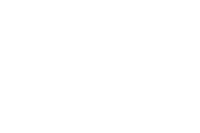

In [21]:
age_data= gis.content.search("https://services1.arcgis.com/ajkPMiuiqxF9xEgP/arcgis/rest/services/65_Edited_1/FeatureServer",'feature layer')[0]
age_data

In [22]:
##Visualization of 65+ population (Choropleth map)
map2 = gis.map("NH", zoomlevel=7)
map2.basemap = 'gray-vector'
map2

MapView(layout=Layout(height='400px', width='100%'))

In [23]:
map2.add_layer(census_tract)
map2.legend = True

In order to join our non-spatial data (age demographies) with our spatial data (census tract area and boundaries), we converted both feature layers into seperate dataframes. From there, we used the `merge` function to make an outer join on the shared column `"GEOID"`.

In [24]:
census_tract_flayer = census_tract.layers[0]
census_tract_df = census_tract_flayer.query(as_df=True)
census_tract_df.columns

Index(['FID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'Shape__Area', 'Shape__Length', 'SHAPE'],
      dtype='object')

In [25]:
age_data_flayer = age_data.layers[0]
age_data_df = age_data_flayer.query(as_df=True)
age_data_df.columns

Index(['FID', 'GEOID', 'GEO_ID', 'NAME', 'Total_Pop', 'TotalPop_6',
       'TotalPop_7', 'Shape__Area', 'Shape__Length'],
      dtype='object')

In [26]:
new_df1=pd.merge(census_tract_df, age_data_df, on='GEOID', how = 'outer')
new_df1

,FID_x,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,Shape__Length_x,SHAPE,FID_y,GEO_ID,NAME_y,Total_Pop,TotalPop_6,TotalPop_7,Shape__Area_y,Shape__Length_y
0,1,33,011,013100,33011013100,131,Census Tract 131,G5020,S,38653612,...,39368.898696,"{'rings': [[[-7957817.81648929, 5291015.248591...",128,1400000US33011013100,"Census Tract 131, Hillsborough County, New Ham...",8566,1188,13.9,None,None
1,2,33,003,955600,33003955600,9556,Census Tract 9556,G5020,S,584239687,...,163041.367953,"{'rings': [[[-7966535.25583121, 5448926.547511...",20,1400000US33003955600,"Census Tract 9556, Carroll County, New Hampshire",5137,1190,23.2,None,None
2,3,33,003,955400,33003955400,9554,Census Tract 9554,G5020,S,74938224,...,82668.949085,"{'rings': [[[-7920028.85209788, 5464397.357467...",18,1400000US33003955400,"Census Tract 9554, Carroll County, New Hampshire",4180,799,19.1,None,None
3,4,33,003,956300,33003956300,9563,Census Tract 9563,G5020,S,154607394,...,93693.120913,"{'rings': [[[-7962942.86243877, 5429120.448903...",25,1400000US33003956300,"Census Tract 9563, Carroll County, New Hampshire",4099,1201,29.3,None,None
4,5,33,003,955300,33003955300,9553,Census Tract 9553,G5020,S,251876652,...,135834.823053,"{'rings': [[[-7922275.28075723, 5477296.438709...",17,1400000US33003955300,"Census Tract 9553, Carroll County, New Hampshire",6319,1507,23.8,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,291,33,017,088500,33017088500,885,Census Tract 885,G5020,S,153559749,...,93035.193429,"{'rings': [[[-7924923.56842345, 5390697.967786...",226,1400000US33017088500,"Census Tract 885, Strafford County, New Hampshire",4480,668,14.9,None,None
291,292,33,013,032900,33013032900,329,Census Tract 329,G5020,S,3064564,...,16226.672828,"{'rings': [[[-7962717.99312489, 5343830.419008...",175,1400000US33013032900,"Census Tract 329, Merrimack County, New Hampshire",4904,1099,22.4,None,None
292,293,33,013,037000,33013037000,370,Census Tract 370,G5020,S,113639099,...,70506.986263,"{'rings': [[[-7975633.39709937, 5367333.088173...",239,1400000US33013037000,"Census Tract 370, Merrimack County, New Hampshire",2357,425,18.0,None,None
293,294,33,013,038000,33013038000,380,Census Tract 380,G5020,S,64460538,...,59468.454054,"{'rings': [[[-7983443.5751427, 5367000.0643116...",240,1400000US33013038000,"Census Tract 380, Merrimack County, New Hampshire",4004,853,21.3,None,None


This new dataframe now contains age data linked to the associated tract. We needed to convert this `df` back to a feature layer so that we could use it in a chloropleth map.

In [27]:
age_df_lyr1 = new_df1.spatial.to_featurelayer('age_census_1')
age_df_lyr1

<Item title:"age_census_1" type:Feature Layer Collection owner:f002w4d_Dartmouth>

In [28]:
map3 = gis.map("NH", zoomlevel=7)
map3.basemap = 'gray-vector'
map3

MapView(layout=Layout(height='400px', width='100%'))

To create a chloropleth map with custom 'breaks' based on the percentage of tract population over the age of 65, we use a renderer. `Renderers` define how to visually represent a feature layer by defining `symbols` to represent individual features. The spatial dataframe we have provides us with functionality to control the way features appear by choosing the symbol the renderer uses. This information will show up in the above `map3`.

In [29]:
map3_renderer = {"renderer": "autocast", #This tells python to use JS autocasting
                 "type": "classBreaks",  
                 "field":"TotalPop_7",
                 "minValue":0}

map3_renderer["visualVariables"] = [{   "type": "colorInfo",
                                        "field": "TotalPop_7",
                                        "stops": [  {
                                                        "value": 8,
                                                        "color": [237,248,251,204],
                                                        "label": "< 8"
                                                    },
                                                    {
                                                        "value": 15,
                                                        "color": [179,205,227,204],
                                                        "label": "8~15"
                                                    },
                                                    {
                                                        "value": 20,
                                                        "color": [140,150,198,204],
                                                        "label": "16~20"
                                                    },
                                                    {
                                                        "value": 25,
                                                        "color": [136,86,167,204],
                                                        "label": "21~25"
                                                    },
                                                    {
                                                        "value": 38,
                                                        "color": [129,15,124,204],
                                                        "label": "> 35"
                                                    }]
                                    }]

map3_renderer["classBreakInfos"] = [{   "symbol": {
                                            "color": [170,170,170,204],
                                            "outline": {
                                                "color": [153,153,153,255],
                                                "width": 0.375,
                                                "type": "esriSLS",
                                                "style": "esriSLSSolid"
                                            },
                                            "type": "esriSFS",
                                            "style": "esriSFSSolid"
                                        },
                                        "classMaxValue": 100
                                    }]

map3.add_layer(age_df_lyr1,
               { "type": "FeatureLayer",
                 "renderer": map3_renderer,
                 "field_name":"TotalPop_7",
                 "minValue":0})

map3.legend = True


### Internet Access Data

Additionally, a person who cannot access the internet will not be equipped to use telehealth. We mapped census demographic data of people with no internet access, shown as a percentage of their overall census tracts. 

<Item title:"Internet_Access_NH_New" type:Feature Layer Collection owner:f003f5w_Dartmouth>
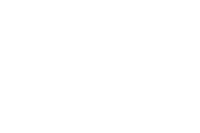

In [30]:
##Import Internet data
internet_access_data = gis.content.search("https://services1.arcgis.com/ajkPMiuiqxF9xEgP/arcgis/rest/services/Internet_Access_NH_New/FeatureServer",'feature service')[0]
internet_access_data

In order to join these spatial and non-spatial layers, we followed the same procedure as with teh age and census tract data. 

In [31]:
internet_access_data_flayer = internet_access_data.layers[0]
internet_access_data_df = internet_access_data_flayer.query(as_df=True)
internet_access_data_df.columns

Index(['FID', 'GEOID', 'GEO_ID', 'NAME', 'TotalPop_6', 'PercentPop',
       'PercentP_1', 'Total_Pop', 'Total_pop_', 'B28002_003', 'B28002_004',
       'B28002_005', 'B28002_006', 'B28002_007', 'B28002_008', 'B28002_009',
       'B28002_010', 'B28002_011', 'B28002_012', 'Total_Pop1', 'Shape__Area',
       'Shape__Length'],
      dtype='object')

In [32]:
census_tract_df.columns

Index(['FID', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'Shape__Area', 'Shape__Length', 'SHAPE'],
      dtype='object')

In [33]:
int_ac_df=pd.merge(census_tract_df, internet_access_data_df, on='GEOID', how = 'outer')
int_ac_df

,FID_x,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,B28002_006,B28002_007,B28002_008,B28002_009,B28002_010,B28002_011,B28002_012,Total_Pop1,Shape__Area_y,Shape__Length_y
0,1.0,33,011,013100,33011013100,131,Census Tract 131,G5020,S,38653612.0,...,164.0,2741.0,523.0,94.0,0.0,0.0,22.0,54.0,None,None
1,2.0,33,003,955600,33003955600,9556,Census Tract 9556,G5020,S,584239687.0,...,109.0,1559.0,632.0,151.0,30.0,39.0,104.0,255.0,None,None
2,3.0,33,003,955400,33003955400,9554,Census Tract 9554,G5020,S,74938224.0,...,146.0,1579.0,444.0,25.0,0.0,0.0,0.0,168.0,None,None
3,4.0,33,003,956300,33003956300,9563,Census Tract 9563,G5020,S,154607394.0,...,75.0,1423.0,468.0,112.0,27.0,0.0,45.0,141.0,None,None
4,5.0,33,003,955300,33003955300,9553,Census Tract 9553,G5020,S,251876652.0,...,53.0,2472.0,862.0,9.0,5.0,0.0,16.0,284.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,294.0,33,013,038000,33013038000,380,Census Tract 380,G5020,S,64460538.0,...,21.0,1163.0,270.0,33.0,0.0,0.0,12.0,146.0,None,None
294,295.0,33,013,040000,33013040000,400,Census Tract 400,G5020,S,114267231.0,...,27.0,1453.0,327.0,135.0,57.0,19.0,50.0,155.0,None,None
295,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None
296,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,None


In [34]:
int_ac_df.columns

Index(['FID_x', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x',
       'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'Shape__Area_x', 'Shape__Length_x', 'SHAPE', 'FID_y',
       'GEO_ID', 'NAME_y', 'TotalPop_6', 'PercentPop', 'PercentP_1',
       'Total_Pop', 'Total_pop_', 'B28002_003', 'B28002_004', 'B28002_005',
       'B28002_006', 'B28002_007', 'B28002_008', 'B28002_009', 'B28002_010',
       'B28002_011', 'B28002_012', 'Total_Pop1', 'Shape__Area_y',
       'Shape__Length_y'],
      dtype='object')

In [35]:
#excluding the rows that came out as 'NaN' since these caused an error in the next step.
acs_new_df = int_ac_df[int_ac_df['STATEFP'].notna()]
acs_new_df

,FID_x,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,B28002_006,B28002_007,B28002_008,B28002_009,B28002_010,B28002_011,B28002_012,Total_Pop1,Shape__Area_y,Shape__Length_y
0,1.0,33,011,013100,33011013100,131,Census Tract 131,G5020,S,38653612.0,...,164.0,2741.0,523.0,94.0,0.0,0.0,22.0,54.0,None,None
1,2.0,33,003,955600,33003955600,9556,Census Tract 9556,G5020,S,584239687.0,...,109.0,1559.0,632.0,151.0,30.0,39.0,104.0,255.0,None,None
2,3.0,33,003,955400,33003955400,9554,Census Tract 9554,G5020,S,74938224.0,...,146.0,1579.0,444.0,25.0,0.0,0.0,0.0,168.0,None,None
3,4.0,33,003,956300,33003956300,9563,Census Tract 9563,G5020,S,154607394.0,...,75.0,1423.0,468.0,112.0,27.0,0.0,45.0,141.0,None,None
4,5.0,33,003,955300,33003955300,9553,Census Tract 9553,G5020,S,251876652.0,...,53.0,2472.0,862.0,9.0,5.0,0.0,16.0,284.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,291.0,33,017,088500,33017088500,885,Census Tract 885,G5020,S,153559749.0,...,76.0,1320.0,273.0,114.0,19.0,3.0,10.0,132.0,None,None
291,292.0,33,013,032900,33013032900,329,Census Tract 329,G5020,S,3064564.0,...,129.0,1527.0,571.0,12.0,0.0,0.0,16.0,565.0,None,None
292,293.0,33,013,037000,33013037000,370,Census Tract 370,G5020,S,113639099.0,...,36.0,750.0,149.0,76.0,25.0,5.0,15.0,95.0,None,None
293,294.0,33,013,038000,33013038000,380,Census Tract 380,G5020,S,64460538.0,...,21.0,1163.0,270.0,33.0,0.0,0.0,12.0,146.0,None,None


In [36]:
access_df_lyr = acs_new_df.spatial.to_featurelayer('int_acs_census')
access_df_lyr

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/arcgis/features/geo/_accessor.py:1169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._data[col] = GeoArray(self._data[col])


<Item title:"int_acs_census" type:Feature Layer Collection owner:f002w4d_Dartmouth>

In [37]:
map4 = gis.map("NH", zoomlevel=7)
map4.basemap = 'gray-vector'
map4

MapView(layout=Layout(height='400px', width='100%'))

In [38]:
map4_renderer = {"renderer": "autocast", #This tells python to use JS autocasting
                 "type": "classBreaks",  
                 "field":"PercentPop",
                 "minValue":0}

map4_renderer["visualVariables"] = [{   "type": "colorInfo",
                                        "field": "PercentPop",
                                        "stops": [  {
                                                        "value": 5,
                                                        "color": [255,255,204,204],
                                                        "label": "less than 5"
                                                    },
                                                    {
                                                        "value": 10,
                                                        "color": [161,218,180,204],
                                                        "label": "5~10"
                                                    },
                                                    {
                                                        "value": 20,
                                                        "color": [65,182,196,204],
                                                        "label": "10~20"
                                                    },
                                                    {
                                                        "value": 35,
                                                        "color": [37,52,148,204],
                                                        "label": "greater than 20"
                                                    }]
                                    }]

map4_renderer["classBreakInfos"] = [{   "symbol": {
                                            "color": [170,170,170,204],
                                            "outline": {
                                                "color": [153,153,153,255],
                                                "width": 0.375,
                                                "type": "esriSLS",
                                                "style": "esriSLSSolid"
                                            },
                                            "type": "esriSFS",
                                            "style": "esriSFSSolid"
                                        },
                                        "classMaxValue": 100
                                    }]

map4.add_layer(access_df_lyr,
               { "type": "FeatureLayer",
                 "renderer": map4_renderer,
                 "field_name":"PercentPop",
                 "minValue":0})

map4.legend = True

## Isolating Tracts Outside of the Service Areas

Given that we have now mapped the tracts based on % population over the age of 65 and % population without internet access, we wanted to find out if there were **tracts with high-need populations outside of the hospital service areas**.

To do this, we needed to create a feature layer of just the service area geometry so that we could determine which tracts did not fall within the service area. For the `service_area_fset` (created earlier), we created a new dataframe to be converted into an independant feature layer.

In [39]:
sa_poly_df=service_area_fset.sdf['SHAPE']
sa_poly_df

0     {"rings": [[[-71.69758331999998, 43.3241720090...
1     {"rings": [[[-72.12270908399995, 43.1923448440...
2     {"rings": [[[-71.69623585299996, 42.9599068270...
3     {"rings": [[[-71.94708924899999, 43.1847091990...
4     {"rings": [[[-71.49478957199995, 42.8265076180...
5     {"rings": [[[-71.47255637099994, 42.8673807760...
6     {"rings": [[[-71.85186826399996, 43.0935306140...
7     {"rings": [[[-71.52308637399994, 43.0908356810...
8     {"rings": [[[-71.56440868799996, 43.2015525330...
9     {"rings": [[[-71.57406553399994, 43.4582449510...
10    {"rings": [[[-72.25812949299996, 43.5754745600...
11    {"rings": [[[-72.60936916299994, 43.8685485810...
12    {"rings": [[[-72.12360739499996, 43.9693840100...
13    {"rings": [[[-71.91789413599997, 43.6244325190...
14    {"rings": [[[-71.64346007199998, 43.6170214520...
15    {"rings": [[[-71.41753481099994, 43.7335773270...
16    {"rings": [[[-71.68276118599994, 44.1079485090...
17    {"rings": [[[-72.01872956499994, 44.399001

In [40]:
#excluding 'FromBreak' column data since it was '0' and created an error in the conversion to a feature layer.
sa_new_df = service_area_df.loc[:, service_area_df.columns != 'FromBreak']
sa_new_df

,ObjectID,FacilityID,Name,ToBreak,Shape_Length,Shape_Area,SHAPE
0,1,17,CONCORD HOSPITAL : 0 - 24.1859951569205,24.185995,0.760060,0.014935,"{""rings"": [[[-71.69758331999998, 43.3241720090..."
1,2,25,THE CHESHIRE MEDICAL CENTER : 0 - 30,30.000000,7.152957,0.150476,"{""rings"": [[[-72.12270908399995, 43.1923448440..."
2,3,29,NORTHEAST REHABILITATION : 0 - 30,30.000000,2.148860,0.049621,"{""rings"": [[[-71.69623585299996, 42.9599068270..."
3,4,13,MONADNOCK COMMUNITY HOSPITAL : 0 - 30,30.000000,4.025542,0.115740,"{""rings"": [[[-71.94708924899999, 43.1847091990..."
4,5,12,SAINT JOSEPH HOSPITAL AND TRAUMA CENTER : 0 - 30,30.000000,3.797857,0.061421,"{""rings"": [[[-71.49478957199995, 42.8265076180..."
5,6,30,SOUTHERN NEW HAMPSHIRE MEDICAL CENTER : 0 - 21...,21.441245,1.558327,0.015564,"{""rings"": [[[-71.47255637099994, 42.8673807760..."
6,7,31,CROTCHED MOUNTAIN REHABILITATION CENTER : 0 - 30,30.000000,1.030452,0.027103,"{""rings"": [[[-71.85186826399996, 43.0935306140..."
7,8,27,CATHOLIC MEDICAL CENTER : 0 - 30,30.000000,1.824691,0.039021,"{""rings"": [[[-71.52308637399994, 43.0908356810..."
8,9,15,HEALTHSOUTH REHABILITATION HOSPITAL : 0 - 1.66...,1.661092,0.020991,0.000002,"{""rings"": [[[-71.56440868799996, 43.2015525330..."
9,10,14,NEW HAMPSHIRE HOSPITAL : 0 - 30,30.000000,3.604176,0.132577,"{""rings"": [[[-71.57406553399994, 43.4582449510..."


In [41]:
sa_poly_lyr = sa_new_df.spatial.to_featurelayer('SA_SHAPE')
sa_poly_lyr

<Item title:"SA_SHAPE" type:Feature Layer Collection owner:f002w4d_Dartmouth>

Now that we have two feature layers, we can use the `arcgis.feature` module function `overlay_layers` to `erase` the area of the census tract layer with which the service area layer overlaps.

In [43]:
from arcgis.features.manage_data import overlay_layers
sa_exc_results=overlay_layers(input_layer=census_tract_flayer, overlay_layer=sa_poly_lyr, overlay_type='Erase', output_name="tracts_remain_9")
sa_exc_results

<Item title:"tracts_remain_9" type:Feature Layer Collection owner:f002w4d_Dartmouth>

In [44]:
map5 = gis.map("NH", zoomlevel=7)
map5.basemap = 'gray-vector'
map5

MapView(layout=Layout(height='400px', width='100%'))

In [45]:
map5.add_layer(sa_exc_results)

## Internet Speeds by Census Block

From the population that has access to the Internet, we then identify which among them has relatively fast Internet speed. We obtained Internet speed data on a census block level, and we first import the census as well as the internet speed data.

<Item title:"NH_censusblocks2010" type:Feature Layer Collection owner:f003ddw_Dartmouth>
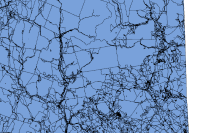

In [46]:
NH_census_block = gis.content.search("https://services1.arcgis.com/ajkPMiuiqxF9xEgP/arcgis/rest/services/NH_censusblocks2010/FeatureServer",'feature layer')[0]
NH_census_block

<Item title:"NHFCCDATA_ALL_SHAPEFILE" type:Feature Layer Collection owner:f003ddw_Dartmouth>
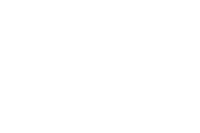

In [47]:
Internet_Speed_Data = gis.content.search("https://services1.arcgis.com/ajkPMiuiqxF9xEgP/arcgis/rest/services/NHFCCDATA_ALL_SHAPEFILE/FeatureServer","feature layer")[0]
Internet_Speed_Data

We then create spatial dataframe for the imported census block and Internet speed layers.

In [48]:
NH_census_block_flayer = NH_census_block.layers[0]
NH_census_block_df = NH_census_block_flayer.query(as_df=True)
NH_census_block_df.columns

Index(['ALAND10', 'AWATER10', 'BLOCKCE10', 'COUNTYFP10', 'FID', 'FUNCSTAT10',
       'GEOID10', 'INTPTLAT10', 'INTPTLON10', 'MTFCC10', 'NAME10', 'SHAPE',
       'STATEFP10', 'Shape__Area', 'Shape__Length', 'TRACTCE10', 'UACE10',
       'UATYPE', 'UR10'],
      dtype='object')

In the spatial dataframe of the Internet speed below, column "maxadup" represents the maximum upload speed and is the variable of interest.

In [49]:
NH_Internet_Speed_Data_flayer = Internet_Speed_Data.layers[0]
NH_Internet_Speed_Data_df = NH_Internet_Speed_Data_flayer.query(as_df=True)
NH_Internet_Speed_Data_df.columns

Index(['FID', 'GEOID10', 'Shape__Area', 'Shape__Length', 'business',
       'consumer', 'dbaname', 'frn', 'hocofinal', 'hoconum', 'holdingcom',
       'logrecno', 'maxaddown', 'maxadup', 'provider_i', 'providerna',
       'stateabbr', 'techcode'],
      dtype='object')

Because the Internet speed spatial dataframe includes Internet speed data measured by several providers in a single census block, there are multiple Internet upload speeds within one census block. Therefore, in the code below, we take out the duplicates and preserve the smallest measurement of Internet speed in each unique census block.

In [50]:
NH_New_Internet_Speed_df = NH_Internet_Speed_Data_df.sort_values('maxadup', ascending=True).drop_duplicates('GEOID10').sort_index()
NH_New_Internet_Speed_df

,FID,GEOID10,Shape__Area,Shape__Length,business,consumer,dbaname,frn,hocofinal,hoconum,holdingcom,logrecno,maxaddown,maxadup,provider_i,providerna,stateabbr,techcode
10,11,330019653001003,None,None,0,1,United States Cellular Corporation,4372322,"Telephone and Data Systems, Inc.",131310,"Telephone and Data Systems, Inc.",3769894,2,0.064,55394,UNITED STATES CELLULAR CORPORATION,NH,70
12,13,330099608003002,None,None,0,1,United States Cellular Corporation,4372322,"Telephone and Data Systems, Inc.",131310,"Telephone and Data Systems, Inc.",3785780,2,0.064,55394,UNITED STATES CELLULAR CORPORATION,NH,70
14,15,330019661004039,None,None,0,1,United States Cellular Corporation,4372322,"Telephone and Data Systems, Inc.",131310,"Telephone and Data Systems, Inc.",3771671,2,0.064,55394,UNITED STATES CELLULAR CORPORATION,NH,70
36,37,330199751001098,None,None,0,1,United States Cellular Corporation,4372322,"Telephone and Data Systems, Inc.",131310,"Telephone and Data Systems, Inc.",3802069,2,0.064,55394,UNITED STATES CELLULAR CORPORATION,NH,70
40,41,330110200002013,None,None,0,1,United States Cellular Corporation,4372322,"Telephone and Data Systems, Inc.",131310,"Telephone and Data Systems, Inc.",3794515,2,0.064,55394,UNITED STATES CELLULAR CORPORATION,NH,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319830,319831,330079502001103,None,None,1,0,GCI Communication Corp.,1568880,GCI Holdings LLC,130534,GCI Holdings LLC,58860246,0,0.000,59349,GCI Communication Corp.,NH,60
319841,319842,330079503001349,None,None,1,1,Viasat Inc,4963088,"ViaSat, Inc.",290111,"ViaSat, Inc.",14899659,35,3.000,56004,"ViaSat, Inc.",NH,60
319844,319845,330110022003010,None,None,1,0,Consolidated Communications,16022618,"Consolidated Communications, Inc.",130335,"Consolidated Communications, Inc.",21107222,0,0.000,56663,Consolidated Communications of Northern New En...,NH,20
319853,319854,330130425002037,None,None,1,0,GCI Communication Corp.,1568880,GCI Holdings LLC,130534,GCI Holdings LLC,58880314,0,0.000,59349,GCI Communication Corp.,NH,60


Now that we took out the duplicates, there are 48837 rows, which match the the number of rows in the census block spatial dataframe.Next, we join the two dataframes together.

In [51]:
speed_df = pd.merge(NH_census_block_df, NH_New_Internet_Speed_df, on='GEOID10', how = 'outer')
speed_df

,ALAND10,AWATER10,BLOCKCE10,COUNTYFP10,FID_x,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,MTFCC10,...,hocofinal,hoconum,holdingcom,logrecno,maxaddown,maxadup,provider_i,providerna,stateabbr,techcode
0,0,113800,1014,007,1,S,330079503001014,+44.9394997,-071.0852961,G5040,...,"ViaSat, Inc.",290111,"ViaSat, Inc.",14899324,35,3.000,56004,"ViaSat, Inc.",NH,60
1,0,53083,1453,007,2,S,330079501001453,+44.9737562,-071.1089505,G5040,...,"ViaSat, Inc.",290111,"ViaSat, Inc.",14898551,35,3.000,56004,"ViaSat, Inc.",NH,60
2,0,33696,2058,009,3,S,330099604002058,+44.0890378,-071.7327719,G5040,...,"Telephone and Data Systems, Inc.",131310,"Telephone and Data Systems, Inc.",3784994,2,0.064,55394,UNITED STATES CELLULAR CORPORATION,NH,70
3,0,75429,2017,007,4,S,330079503002017,+44.5917138,-071.1910803,G5040,...,"Telephone and Data Systems, Inc.",131310,"Telephone and Data Systems, Inc.",3781891,2,0.064,55394,UNITED STATES CELLULAR CORPORATION,NH,70
4,0,25358,5012,007,5,S,330079507005012,+44.4889281,-071.2061142,G5040,...,"Telephone and Data Systems, Inc.",131310,"Telephone and Data Systems, Inc.",3782761,2,0.064,55394,UNITED STATES CELLULAR CORPORATION,NH,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48832,194639,0,3000,015,48833,S,330151003013000,+42.7850556,-071.2436840,G5040,...,GCI Holdings LLC,130534,GCI Holdings LLC,58885937,0,0.000,59349,GCI Communication Corp.,NH,60
48833,18599,0,1017,011,48834,S,330110019001017,+42.9777848,-071.4541941,G5040,...,"Consolidated Communications, Inc.",130335,"Consolidated Communications, Inc.",21106853,0,0.000,56663,Consolidated Communications of Northern New En...,NH,20
48834,7100,0,1047,015,48835,S,330150640001047,+42.9164462,-070.8647324,G5040,...,Crown Castle International Corp.,400092,Crown Castle International Corp.,3073914,0,0.000,55027,Crown Castle Fiber LLC,NH,50
48835,615702,0,2013,015,48836,S,330151075002013,+43.0362403,-070.8271801,G5040,...,GCI Holdings LLC,130534,GCI Holdings LLC,58887639,0,0.000,59349,GCI Communication Corp.,NH,60


In order to convert the spatial dataframe back to a layer, we need to take out the string type in the dataframe.

In [52]:
new_speed_df = speed_df.drop(columns = ['hocofinal','holdingcom','providerna','dbaname','business','consumer','techcode','provider_i','frn','hoconum','logrecno','stateabbr','ALAND10','AWATER10','COUNTYFP10'])
new_speed_df

,BLOCKCE10,FID_x,FUNCSTAT10,GEOID10,INTPTLAT10,INTPTLON10,MTFCC10,NAME10,SHAPE,STATEFP10,...,Shape__Length_x,TRACTCE10,UACE10,UATYPE,UR10,FID_y,Shape__Area_y,Shape__Length_y,maxaddown,maxadup
0,1014,1,S,330079503001014,+44.9394997,-071.0852961,G5040,Block 1014,"{'rings': [[[-7914130.04082604, 5609620.916936...",33,...,10710.037273,950300,,,R,202843,None,None,35,3.000
1,1453,2,S,330079501001453,+44.9737562,-071.1089505,G5040,Block 1453,"{'rings': [[[-7916566.60303704, 5617590.563902...",33,...,5825.261927,950100,,,R,214422,None,None,35,3.000
2,2058,3,S,330099604002058,+44.0890378,-071.7327719,G5040,Block 2058,"{'rings': [[[-7985452.45628823, 5479144.732993...",33,...,1421.410198,960400,,,R,35044,None,None,2,0.064
3,2017,4,S,330079503002017,+44.5917138,-071.1910803,G5040,Block 2017,"{'rings': [[[-7925915.65952053, 5558702.623067...",33,...,5507.888600,950300,,,R,5034,None,None,2,0.064
4,5012,5,S,330079507005012,+44.4889281,-071.2061142,G5040,Block 5012,"{'rings': [[[-7926897.27432635, 5541752.023409...",33,...,1978.983123,950700,,,R,36640,None,None,2,0.064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48832,3000,48833,S,330151003013000,+42.7850556,-071.2436840,G5040,Block 3000,"{'rings': [[[-7931224.47513787, 5279826.217026...",33,...,3303.339258,100301,09271,U,U,43663,None,None,0,0.000
48833,1017,48834,S,330110019001017,+42.9777848,-071.4541941,G5040,Block 1017,"{'rings': [[[-7954379.94000566, 5308594.574091...",33,...,801.319677,001900,53740,U,U,60686,None,None,0,0.000
48834,1047,48835,S,330150640001047,+42.9164462,-070.8647324,G5040,Block 1047,"{'rings': [[[-7888769.32326882, 5299359.657252...",33,...,629.036850,064000,09271,U,U,70598,None,None,0,0.000
48835,2013,48836,S,330151075002013,+43.0362403,-070.8271801,G5040,Block 2013,"{'rings': [[[-7885056.92912757, 5317429.841556...",33,...,6814.739595,107500,71506,U,U,296814,None,None,0,0.000


We convert the spatial dataframe back to a layer.

<Item title:"NH_speed_block" type:Feature Layer Collection owner:f002w4d_Dartmouth>
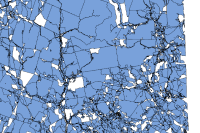

In [55]:
new_speed_lyr = new_speed_df.spatial.to_featurelayer('NH_speed_block')
new_speed_lyr

In [56]:
NH_speed_block = gis.content.search("https://services1.arcgis.com/ajkPMiuiqxF9xEgP/arcgis/rest/services/a48ab9/FeatureServer",'feature layer')[0]
NH_speed_block

<Item title:"speed_block" type:Feature Layer Collection owner:f003f5w_Dartmouth>

In the new layer, "stateabbr" becomes the Internet speed column, and we apply this variable of interest in visualization.

In [57]:
map5 = gis.map("NH", zoomlevel=7)
map5.basemap = 'gray-vector'
map5

MapView(layout=Layout(height='400px', width='100%'))

In [61]:
map5_renderer = {"renderer": "autocast", #This tells python to use JS autocasting
                 "type": "classBreaks",  
                 "field":"stateabbr",
                 "minValue":0}

map5_renderer["visualVariables"] = [{   "type": "colorInfo",
                                        "field": "stateabbr",
                                        "stops": [  {
                                                        "value": 1,
                                                        "color": [237,248,251,204],
                                                        "label": "less than 1"
                                                    },
                                                    {
                                                        "value": 1000,
                                                        "color": [0,109,44,204],
                                                        "label": "greater than or equal to 1"
                                                    }]
                                    }]

map5_renderer["classBreakInfos"] = [{   "symbol": {
                                            "color": [170,170,170,204],
                                            "outline": {
                                                "color": [153,153,153,255],
                                                "width": 0.375,
                                                "type": "esriSLS",
                                                "style": "esriSLSSolid"
                                            },
                                            "type": "esriSFS",
                                            "style": "esriSFSSolid"
                                        },
                                        "classMaxValue": 1000
                                    }]

map5.add_layer(NH_speed_block,
               { "type": "FeatureLayer",
                 "renderer": map5_renderer,
                 "field_name":"stateabbr",
                 "minValue": 0})

In [60]:
map5.legend=True

## Data Analysis

The groups who are most in need of telehealth are statistically insignificantly correlated. A correlation analysis of ‘percentage of population over 65’ compared to ‘percentage of population with no internet’ yielded: 0.19664679. This means that there is not one fix to satisfy both groups, but rather more elaborate healthcare rollouts are required if telehealth is to last beyond the pandemic.
***
Out of 295 census tracts, three stood out as particularly lacking access to telehealth. **9501, 9502, 9504 are on the top 15 list of worst covered areas by existing healthcare in addition to the top 15 list of least access to internet service.** Here is a profile of each tract: 
* 9501 - Coos County, NH
    * Total Pop: 982
    * Unserviced area: 351 mi^2
    * No internet service: 21%
    * Population over age of 65: 35.3 
    
* 9502 - Coos County, NH
    * Total Pop: 1270
    * Unserviced area: 46.3 mi^2
    * No internet service:  24%
    * Population over age of 65: 26%
    
* 9504 - Coos County, NH
    * Total Pop: 1494
    * Unserviced area: 129.5 mi^2
    * No internet service:  19%
    * Population over age of 65: 20%
    
The data shows that these populations, though relatively small, are some of the most underserved by telehealth in the state at a proportional level. 




## Possible Limitations

The conclusion of this study was based on proportional analyses. Smaller communities are disproportionately shown to have greater need using this level of analysis. With more time a new analysis could be done to determine the most in-need census tracts on a quantitative basis. 

Data does not take into account clinics that are directly over the border in ME, MA, VT. NH is a very interconnected state with its neighbors. Many resources are shared like education and recreation. It is only expected that some border communities use facilities in other states.

Some data comes from a time before COVID. It is possible that necessity has made those without internet purchase internet and those with slow service upgrade their service.

The join of census blocks to internet service speeds was a one-to-many join, with the join taking the first pairing it saw. With more time we would have averaged the upload speeds of each census block or taken the highest to give a more complete picture. 

## Bibliography

https://nhhealthcost.nh.gov/guide/question/what-is-an-urgent-care-clinic

https://decisiondata.org/internet/what-is-a-good-internet-speed/#:~:text=Although%20the%20FCC%20recommends%20speeds,online%20games%20or%20connecting%20multiple 

https://law.justia.com/codes/new-hampshire/2006/nhtoc-xi/151-c-2.html 

https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html 

https://dartmouth.maps.arcgis.com/home/notebook/notebook.html?id=48d685e1a3e94536803b5049e811f847

US Census Data
